In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker-ir2"  # change to your desired S3 prefix
region = sess.boto_region_name

role = sagemaker.get_execution_role()

In [2]:
import boto3
import io
import json
import time

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd

import s3fs
import gzip

In [3]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# download the data
s3 = boto3.client("s3")
datafile = "consumables.csv"
s3.download_file(
    "sagemaker-ir2",
    "Dataset/gl-level/consumables.csv",
    datafile,
)

# # show readme
# display(Markdown("README.md"))

# read the input file, and display sample rows/columns
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 50)
dfc = pd.read_csv(datafile, encoding='latin-1')


dfc.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


,GL_PRODUCT_GROUP,PRODUCT_CATEGORY_CODE,TIME_PERIOD,DDAA_ORDER_GMS,TOTAL_ORDERED_UNITS,DDAA_SHIP_GMS,DDAA_SHIP_UNITS,TOTAL_ORDERED_PROD_SALES_AMT,DDAA_REFUNDED_AMOUNT,DDAA_GROSS_ORDER_GMS,DDAA_GROSS_ORDER_UNITS,DDAA_GROSS_SHIP_GMS,DDAA_GROSS_SHIP_UNITS
0,194.0,19401100,2022-05-09,8.021057e+06,233526.0,7.657874e+06,231768.0,8.014605e+06,381730.270000,8.135858e+06,237869.0,8.038382e+06,232865.0
1,370.0,37000100,2022-05-09,5.198169e+06,388293.0,5.106204e+06,382515.0,5.194338e+06,19931.270000,5.202204e+06,388602.0,5.126354e+06,382770.0
2,194.0,19409500,2022-05-09,2.997970e+05,15291.0,2.739610e+05,15051.0,3.023049e+05,24912.597927,3.050406e+05,15627.0,2.987258e+05,15131.0
3,325.0,32509000,2022-05-09,3.273955e+05,34754.0,3.054216e+05,33088.0,3.307602e+05,3563.490000,3.399752e+05,35370.0,3.089775e+05,33154.0
4,121.0,12108800,2022-05-09,2.217893e+04,18693.0,2.228757e+04,21037.0,4.237197e+05,427.460000,2.284376e+04,18706.0,2.271503e+04,21144.0


In [5]:
# # download the data
# s3 = boto3.client("s3")
# datafile = "data.csv"
# s3.download_file(
#     "broadwayinsightsmodelparams-dataaggregationbucket-1wi5vjqbuzwnp",
#     "ir2-custom-prediction/region=NA/productfamily=Consumables/data.csv",
#     datafile,
# )

# # # show readme
# # display(Markdown("README.md"))

# # read the input file, and display sample rows/columns
# pd.set_option("display.max_columns", 500)
# pd.set_option("display.max_rows", 50)
# dfc = pd.read_csv(datafile, encoding='latin-1')
# dfc.head()

In [6]:
print(dfc.TIME_PERIOD.min())
print(dfc.TIME_PERIOD.max())
print(dfc.GL_PRODUCT_GROUP.max())

2018-04-30
2022-05-09
751.0


In [7]:
# create a new column as target, represent Net GMS
# dfc['Net_GMS'] = dfc['DDAA_SHIP_GMS'] - dfc['DDAA_REFUNDED_AMOUNT']

dfc['TIME_PERIOD'] = pd.to_datetime(dfc['TIME_PERIOD'], format='%Y-%m-%d')

In [8]:
dfc.dtypes

GL_PRODUCT_GROUP                       float64
PRODUCT_CATEGORY_CODE                   object
TIME_PERIOD                     datetime64[ns]
DDAA_ORDER_GMS                         float64
TOTAL_ORDERED_UNITS                    float64
DDAA_SHIP_GMS                          float64
DDAA_SHIP_UNITS                        float64
TOTAL_ORDERED_PROD_SALES_AMT           float64
DDAA_REFUNDED_AMOUNT                   float64
DDAA_GROSS_ORDER_GMS                   float64
DDAA_GROSS_ORDER_UNITS                 float64
DDAA_GROSS_SHIP_GMS                    float64
DDAA_GROSS_SHIP_UNITS                  float64
dtype: object

In [9]:
dfc.GL_PRODUCT_GROUP = dfc.GL_PRODUCT_GROUP.astype(object)

In [10]:
dfc.isnull().sum()

GL_PRODUCT_GROUP                0
PRODUCT_CATEGORY_CODE           0
TIME_PERIOD                     0
DDAA_ORDER_GMS                  0
TOTAL_ORDERED_UNITS             0
DDAA_SHIP_GMS                   0
DDAA_SHIP_UNITS                 0
TOTAL_ORDERED_PROD_SALES_AMT    0
DDAA_REFUNDED_AMOUNT            0
DDAA_GROSS_ORDER_GMS            0
DDAA_GROSS_ORDER_UNITS          0
DDAA_GROSS_SHIP_GMS             0
DDAA_GROSS_SHIP_UNITS           0
dtype: int64

In [11]:
deepardata = dfc[['DDAA_ORDER_GMS','TIME_PERIOD','GL_PRODUCT_GROUP']].groupby(['GL_PRODUCT_GROUP','TIME_PERIOD']).sum().reset_index()
deepardata.head()

,GL_PRODUCT_GROUP,TIME_PERIOD,DDAA_ORDER_GMS
0,75.0,2018-04-30,8.286176e+06
1,75.0,2018-05-07,3.235147e+07
2,75.0,2018-05-14,3.253046e+07
3,75.0,2018-05-21,3.108685e+07
4,75.0,2018-05-28,3.214585e+07


In [12]:
deepardata.dtypes

GL_PRODUCT_GROUP           float64
TIME_PERIOD         datetime64[ns]
DDAA_ORDER_GMS             float64
dtype: object

As described in Amazon SageMaker DeepAR input/output interface section, we will convert the data into array, and use 0 for the violation count when data for a given camera on a given date is not available. Using the Matplotlib library we display each camera location as a timeseries to visualize the data

Unique GL Product Group 13
Minimum record week is 2018-04-30 00:00:00, maximum record week is 2022-05-09 00:00:00


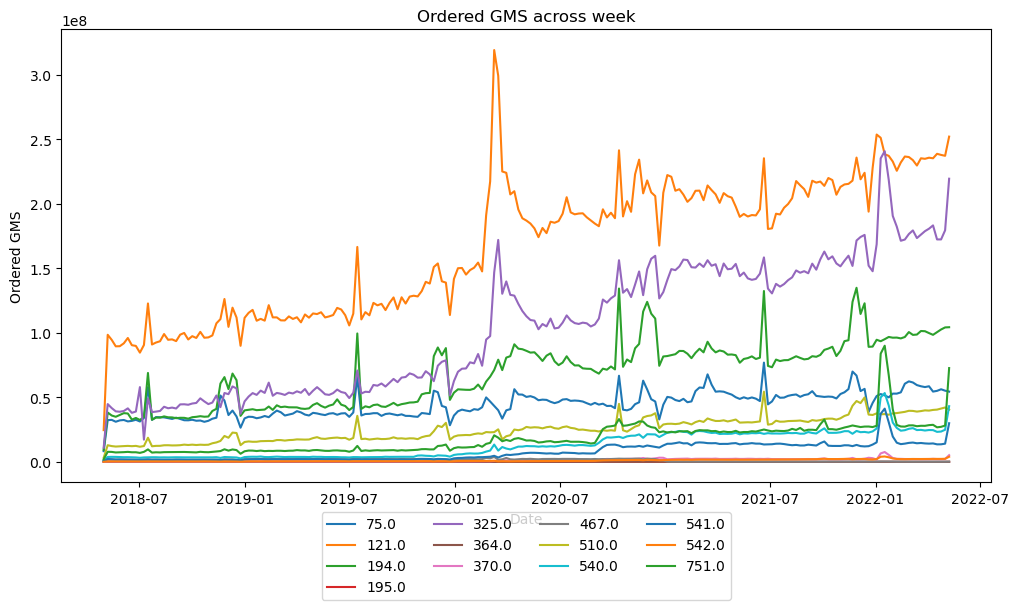

In [13]:
unique_prod = deepardata.GL_PRODUCT_GROUP.unique()
idx = pd.date_range(deepardata.TIME_PERIOD.min(), deepardata.TIME_PERIOD.max(), freq = 'W-MON')
number_of_prod = len(unique_prod)
print("Unique GL Product Group {}".format(number_of_prod))
print(
    "Minimum record week is {}, maximum record week is {}".format(
        deepardata.TIME_PERIOD.min(), deepardata.TIME_PERIOD.max()
    )
)


gms_list = []
for key in unique_prod:
    temp_df = deepardata[["TIME_PERIOD", "DDAA_ORDER_GMS"]][deepardata.GL_PRODUCT_GROUP == key]
    temp_df.set_index(["TIME_PERIOD"], inplace=True)
    temp_df.index = pd.DatetimeIndex(temp_df.index)
    temp_df = temp_df.reindex(idx, fill_value=0)
    gms_list.append(temp_df["DDAA_ORDER_GMS"])

plt.figure(figsize=(12, 6), dpi=100, facecolor="w")
for key, prod in enumerate(unique_prod):
    plt.plot(gms_list[key], label=prod)

plt.ylabel("Ordered GMS")
plt.xlabel("Date")
plt.title("Ordered GMS across week")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), shadow=False, ncol=4)
plt.show()

In [14]:
idx

DatetimeIndex(['2018-04-30', '2018-05-07', '2018-05-14', '2018-05-21',
               '2018-05-28', '2018-06-04', '2018-06-11', '2018-06-18',
               '2018-06-25', '2018-07-02',
               ...
               '2022-03-07', '2022-03-14', '2022-03-21', '2022-03-28',
               '2022-04-04', '2022-04-11', '2022-04-18', '2022-04-25',
               '2022-05-02', '2022-05-09'],
              dtype='datetime64[ns]', length=211, freq='W-MON')

In [15]:
gms_list

[2018-04-30    8.286176e+06
 2018-05-07    3.235147e+07
 2018-05-14    3.253046e+07
 2018-05-21    3.108685e+07
 2018-05-28    3.214585e+07
                   ...     
 2022-04-11    5.444733e+07
 2022-04-18    5.501637e+07
 2022-04-25    5.624063e+07
 2022-05-02    5.514915e+07
 2022-05-09    5.443974e+07
 Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 211, dtype: float64,
 2018-04-30    2.459194e+07
 2018-05-07    9.845662e+07
 2018-05-14    9.449464e+07
 2018-05-21    8.951149e+07
 2018-05-28    8.960112e+07
                   ...     
 2022-04-11    2.351894e+08
 2022-04-18    2.386462e+08
 2022-04-25    2.377980e+08
 2022-05-02    2.371049e+08
 2022-05-09    2.519649e+08
 Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 211, dtype: float64,
 2018-04-30    9.281194e+06
 2018-05-07    3.821637e+07
 2018-05-14    3.591003e+07
 2018-05-21    3.493541e+07
 2018-05-28    3.637384e+07
                   ...     
 2022-04-11    9.841540e+07
 2022-04-18    1.004813e+08
 2022-04-25    1.025620e+08
 2

In [16]:
len(deepardata.TIME_PERIOD.unique())

211

We define prediction length as last 20% (42) weeks, and split the data with last 42 weeks of data as test data. We use rest of the data for training of the model. We can use the last 42 weeks of data to evaluate the accuracy of our trained model. We write the training and test data files in JSON format in the S3 bucket. 

In [18]:
prediction_length = 42

bucket = 'sagemaker-ir2'
prefix = 'deepar'

s3_output_path = "{}/{}/output".format(bucket, prefix)
train_data_path = "s3://{}/{}/train/train.json".format(bucket, prefix)
test_data_path = "s3://{}/{}/test/test.json".format(bucket, prefix)

# Split the data for training and validation/hold out
gms_list_training = []
for i in gms_list:
    gms_list_training.append((i[:-prediction_length]))


def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))


with open("train.json", "w") as fp:
    for ts in gms_list_training:
        fp.write(series_to_jsonline(ts))
        fp.write("\n")
! aws s3 mv train.json $train_data_path

with open("test.json", "w") as fp:
    for ts in gms_list:
        fp.write(series_to_jsonline(ts))
        fp.write("\n")
! aws s3 mv test.json $test_data_path

move: ./train.json to s3://sagemaker-ir2/deepar/train/train.json  
move: ./test.json to s3://sagemaker-ir2/deepar/test/test.json     


In [23]:
len(gms_list_training[0])

169

In [52]:
gms_list_training[0]

2018-04-30    8.286176e+06
2018-05-07    3.235147e+07
2018-05-14    3.253046e+07
2018-05-21    3.108685e+07
2018-05-28    3.214585e+07
                  ...     
2021-06-21    7.690088e+07
2021-06-28    4.454108e+07
2021-07-05    4.681377e+07
2021-07-12    5.182914e+07
2021-07-19    4.966750e+07
Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 169, dtype: float64

In [51]:
gms_list_training

[2018-04-30    8.286176e+06
 2018-05-07    3.235147e+07
 2018-05-14    3.253046e+07
 2018-05-21    3.108685e+07
 2018-05-28    3.214585e+07
                   ...     
 2021-06-21    7.690088e+07
 2021-06-28    4.454108e+07
 2021-07-05    4.681377e+07
 2021-07-12    5.182914e+07
 2021-07-19    4.966750e+07
 Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 169, dtype: float64,
 2018-04-30    2.459194e+07
 2018-05-07    9.845662e+07
 2018-05-14    9.449464e+07
 2018-05-21    8.951149e+07
 2018-05-28    8.960112e+07
                   ...     
 2021-06-21    2.352032e+08
 2021-06-28    1.804363e+08
 2021-07-05    1.809110e+08
 2021-07-12    1.922360e+08
 2021-07-19    1.916613e+08
 Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 169, dtype: float64,
 2018-04-30    9.281194e+06
 2018-05-07    3.821637e+07
 2018-05-14    3.591003e+07
 2018-05-21    3.493541e+07
 2018-05-28    3.637384e+07
                   ...     
 2021-06-21    1.323591e+08
 2021-06-28    7.433253e+07
 2021-07-05    7.331610e+07
 2

In [36]:
gms_list_training[0].index

DatetimeIndex(['2018-04-30', '2018-05-07', '2018-05-14', '2018-05-21',
               '2018-05-28', '2018-06-04', '2018-06-11', '2018-06-18',
               '2018-06-25', '2018-07-02',
               ...
               '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-07',
               '2021-06-14', '2021-06-21', '2021-06-28', '2021-07-05',
               '2021-07-12', '2021-07-19'],
              dtype='datetime64[ns]', length=169, freq='W-MON')

In [49]:
unique_prod = deepardata.GL_PRODUCT_GROUP.unique()

train_data = pd.DataFrame(gms_list_training[0:],columns=gms_list_training[0].index).reset_index().drop(columns = ['index'])

train_data['GL_PRODUCT_GROUP'] = unique_prod

train_data = train_data.set_index('GL_PRODUCT_GROUP')

train_data.head()

,2018-04-30 00:00:00,2018-05-07 00:00:00,2018-05-14 00:00:00,2018-05-21 00:00:00,2018-05-28 00:00:00,2018-06-04 00:00:00,2018-06-11 00:00:00,2018-06-18 00:00:00,2018-06-25 00:00:00,2018-07-02 00:00:00,2018-07-09 00:00:00,2018-07-16 00:00:00,2018-07-23 00:00:00,2018-07-30 00:00:00,2018-08-06 00:00:00,2018-08-13 00:00:00,2018-08-20 00:00:00,2018-08-27 00:00:00,2018-09-03 00:00:00,2018-09-10 00:00:00,2018-09-17 00:00:00,2018-09-24 00:00:00,2018-10-01 00:00:00,2018-10-08 00:00:00,2018-10-15 00:00:00,2018-10-22 00:00:00,2018-10-29 00:00:00,2018-11-05 00:00:00,2018-11-12 00:00:00,2018-11-19 00:00:00,2018-11-26 00:00:00,2018-12-03 00:00:00,2018-12-10 00:00:00,2018-12-17 00:00:00,2018-12-24 00:00:00,2018-12-31 00:00:00,2019-01-07 00:00:00,2019-01-14 00:00:00,2019-01-21 00:00:00,2019-01-28 00:00:00,2019-02-04 00:00:00,2019-02-11 00:00:00,2019-02-18 00:00:00,2019-02-25 00:00:00,2019-03-04 00:00:00,2019-03-11 00:00:00,2019-03-18 00:00:00,2019-03-25 00:00:00,2019-04-01 00:00:00,2019-04-08 00:00:00,2019-04-15 00:00:00,2019-04-22 00:00:00,2019-04-29 00:00:00,2019-05-06 00:00:00,2019-05-13 00:00:00,2019-05-20 00:00:00,2019-05-27 00:00:00,2019-06-03 00:00:00,2019-06-10 00:00:00,2019-06-17 00:00:00,2019-06-24 00:00:00,2019-07-01 00:00:00,2019-07-08 00:00:00,2019-07-15 00:00:00,2019-07-22 00:00:00,2019-07-29 00:00:00,2019-08-05 00:00:00,2019-08-12 00:00:00,2019-08-19 00:00:00,2019-08-26 00:00:00,2019-09-02 00:00:00,2019-09-09 00:00:00,2019-09-16 00:00:00,2019-09-23 00:00:00,2019-09-30 00:00:00,2019-10-07 00:00:00,2019-10-14 00:00:00,2019-10-21 00:00:00,2019-10-28 00:00:00,2019-11-04 00:00:00,2019-11-11 00:00:00,2019-11-18 00:00:00,2019-11-25 00:00:00,2019-12-02 00:00:00,2019-12-09 00:00:00,2019-12-16 00:00:00,2019-12-23 00:00:00,2019-12-30 00:00:00,2020-01-06 00:00:00,2020-01-13 00:00:00,2020-01-20 00:00:00,2020-01-27 00:00:00,2020-02-03 00:00:00,2020-02-10 00:00:00,2020-02-17 00:00:00,2020-02-24 00:00:00,2020-03-02 00:00:00,2020-03-09 00:00:00,2020-03-16 00:00:00,2020-03-23 00:00:00,2020-03-30 00:00:00,2020-04-06 00:00:00,2020-04-13 00:00:00,2020-04-20 00:00:00,2020-04-27 00:00:00,2020-05-04 00:00:00,2020-05-11 00:00:00,2020-05-18 00:00:00,2020-05-25 00:00:00,2020-06-01 00:00:00,2020-06-08 00:00:00,2020-06-15 00:00:00,2020-06-22 00:00:00,2020-06-29 00:00:00,2020-07-06 00:00:00,2020-07-13 00:00:00,2020-07-20 00:00:00,2020-07-27 00:00:00,2020-08-03 00:00:00,2020-08-10 00:00:00,2020-08-17 00:00:00,2020-08-24 00:00:00,2020-08-31 00:00:00,2020-09-07 00:00:00,2020-09-14 00:00:00,2020-09-21 00:00:00,2020-09-28 00:00:00,2020-10-05 00:00:00,2020-10-12 00:00:00,2020-10-19 00:00:00,2020-10-26 00:00:00,2020-11-02 00:00:00,2020-11-09 00:00:00,2020-11-16 00:00:00,2020-11-23 00:00:00,2020-11-30 00:00:00,2020-12-07 00:00:00,2020-12-14 00:00:00,2020-12-21 00:00:00,2020-12-28 00:00:00,2021-01-04 00:00:00,2021-01-11 00:00:00,2021-01-18 00:00:00,2021-01-25 00:00:00,2021-02-01 00:00:00,2021-02-08 00:00:00,2021-02-15 00:00:00,2021-02-22 00:00:00,2021-03-01 00:00:00,2021-03-08 00:00:00,2021-03-15 00:00:00,2021-03-22 00:00:00,2021-03-29 00:00:00,2021-04-05 00:00:00,2021-04-12 00:00:00,2021-04-19 00:00:00,2021-04-26 00:00:00,2021-05-03 00:00:00,2021-05-10 00:00:00,2021-05-17 00:00:00,2021-05-24 00:00:00,2021-05-31 00:00:00,2021-06-07 00:00:00,2021-06-14 00:00:00,2021-06-21 00:00:00,2021-06-28 00:00:00,2021-07-05 00:00:00,2021-07-12 00:00:00,2021-07-19 00:00:00
GL_PRODUCT_GROUP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
75.0,8.286176e+06,3.235147e+07,3.253046e+07,3.108685e+07,3.214585e+07,3.244628e+07,3.133895e+07,3.175517e+07,3.259583e+07,3.127617e+07,3.397351e+07,5.786732e+07,3.255975e+07,3.467971e+07,3.453526e+07,3.447183e+07,3.390154e+07,3.326406e+07,3.423694e+07,3.319963e+07,3.225240e+07,3.219299e+07,3.262961e+07,3.185664e+07,3.202990e+07,3.102871e+07,3.180796e+07,3.344304e+07,3.421211e+07,5.139163e+07,4.749862e+07,3.626081e+07,3.975263e+07

In [50]:
train_data.to_csv('DeepAR_traindata.csv',index=True)

In [26]:
## Train

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker import image_uris


container = image_uris.retrieve(region=region, framework="forecasting-deepar")

deepar = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    use_spot_instances=True,  # use spot instances
    max_run=1800,  # max training time in seconds
    max_wait=1800,  # seconds to wait for spot instance
    output_path="s3://{}/{}".format(bucket, s3_output_path),
    sagemaker_session=sess,
)
freq = "W"
context_length = 42

deepar.set_hyperparameters(
    time_freq=freq, context_length=str(context_length), prediction_length=str(prediction_length)
)

hyperparameter_ranges = {
    "mini_batch_size": IntegerParameter(100, 400),
    "epochs": IntegerParameter(200, 400),
    "num_cells": IntegerParameter(30, 100),
    "likelihood": CategoricalParameter(["negative-binomial", "student-T"]),
    "learning_rate": ContinuousParameter(0.0001, 0.1),
}

objective_metric_name = "test:RMSE"

tuner = HyperparameterTuner(
    deepar,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=10,
    strategy="Bayesian",
    objective_type="Minimize",
    max_parallel_jobs=10,
    early_stopping_type="Auto",
)

s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train/".format(bucket, prefix), content_type="json"
)
s3_input_test = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/test/".format(bucket, prefix), content_type="json"
)

tuner.fit({"train": s3_input_train, "test": s3_input_test}, include_cls_metadata=False)
tuner.wait()

.......................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [27]:
## Host

from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

best_tuning_job_name = tuner.best_training_job()
endpoint = tuner.deploy(
    initial_instance_count=1,
    endpoint_name=best_tuning_job_name,
    instance_type="ml.m4.xlarge",
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer(),
    wait=True,
)


2022-05-18 17:12:07 Starting - Preparing the instances for training
2022-05-18 17:12:07 Downloading - Downloading input data
2022-05-18 17:12:07 Training - Training image download completed. Training in progress.
2022-05-18 17:12:07 Uploading - Uploading generated training model
2022-05-18 17:12:07 Completed - Training job completed
---------!

In [28]:
## Evaluate

class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args, serializer=IdentitySerializer(content_type="application/json"), **kwargs
        )

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be
        called before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the
        (optional) corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + x.index.freq for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df


predictor = DeepARPredictor(endpoint_name=endpoint.endpoint_name, sagemaker_session=sess)

In [59]:
[series_to_obj(gms_list_training[:42][k]) for k in range(len(gms_list_training[:42]))]

[{'start': '2018-04-30 00:00:00',
  'target': [8286175.52979053,
   32351465.275488567,
   32530463.98495974,
   31086853.374158133,
   32145848.084093023,
   32446275.170481965,
   31338949.713996295,
   31755167.63097159,
   32595834.30414705,
   31276173.89783994,
   33973513.211961396,
   57867318.05492068,
   32559753.06198089,
   34679705.91143756,
   34535257.88062464,
   34471827.00955829,
   33901538.80070032,
   33264055.797787692,
   34236944.07118078,
   33199632.343188107,
   32252404.019303624,
   32192987.363461766,
   32629610.712909173,
   31856636.740892533,
   32029895.718914244,
   31028710.295061007,
   31807962.171512973,
   33443037.07078493,
   34212105.161230184,
   51391627.0338841,
   47498621.33632747,
   36260813.82873629,
   39752628.40556185,
   35160824.3392805,
   26474693.67405988,
   33689561.03191786,
   34970061.68963472,
   34812935.3589095,
   33795581.85694971,
   34422926.28835821,
   35535654.71051789,
   34616411.3945009,
   37388152.20947258,

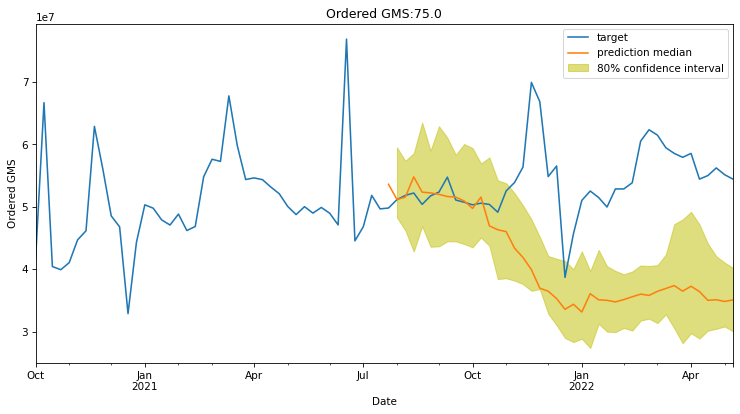

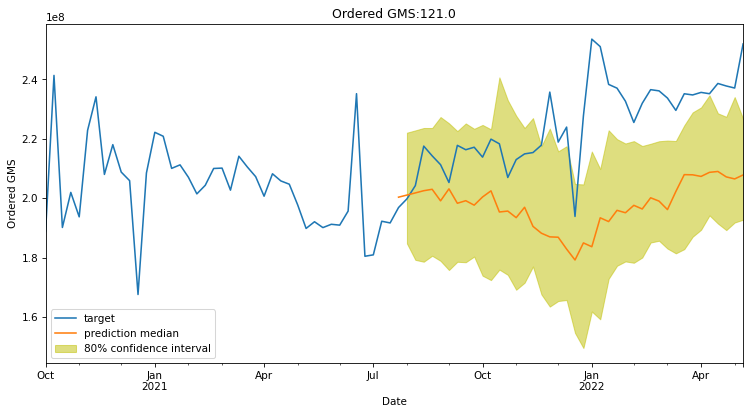

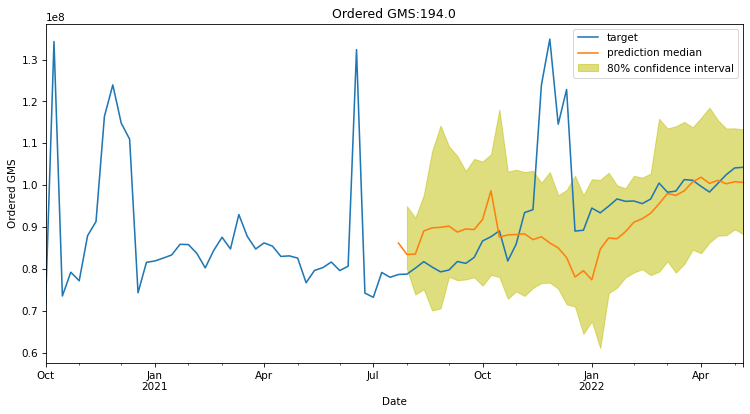

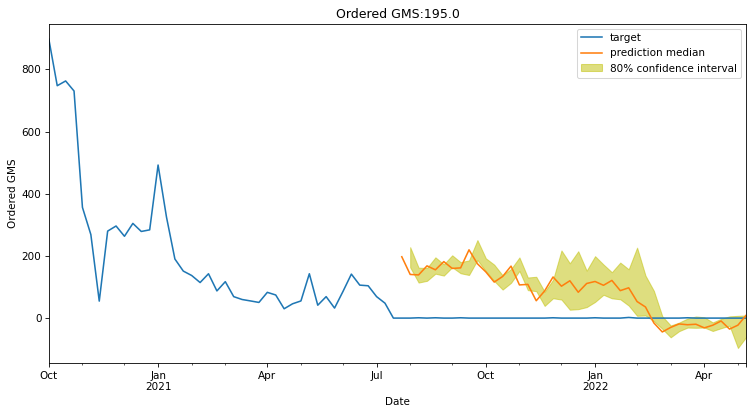

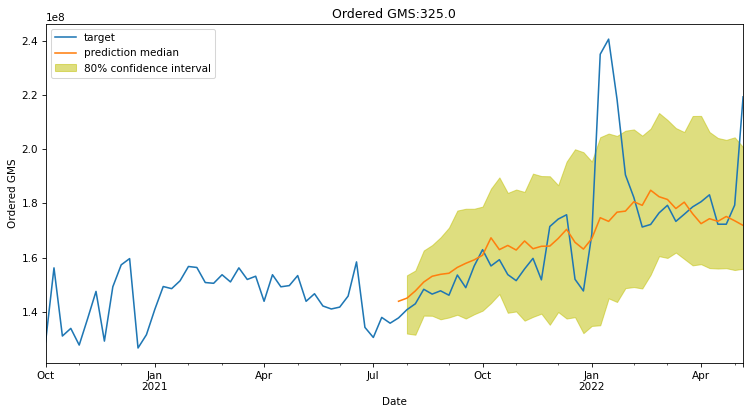

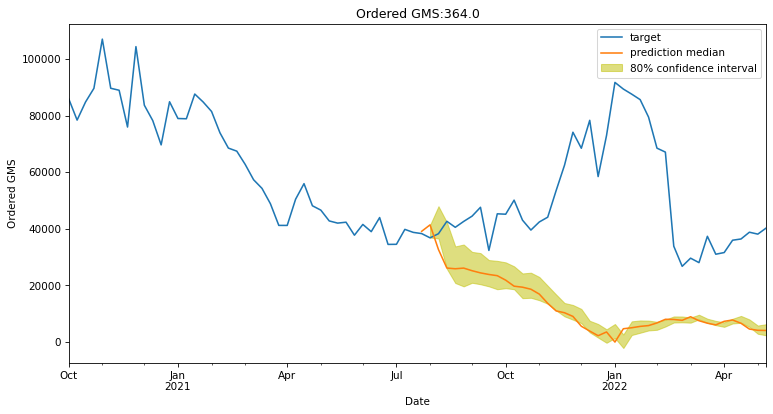

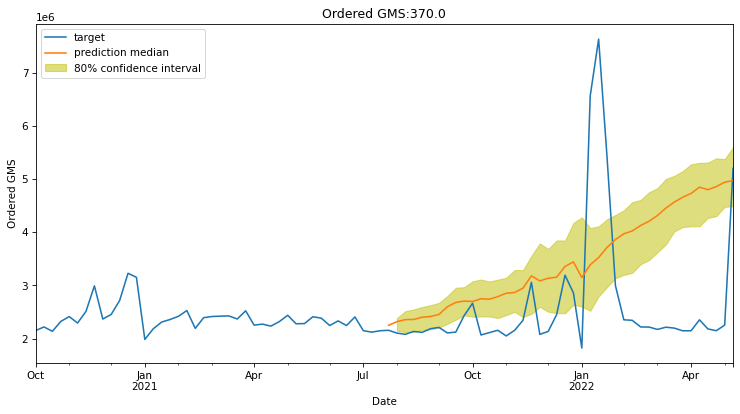

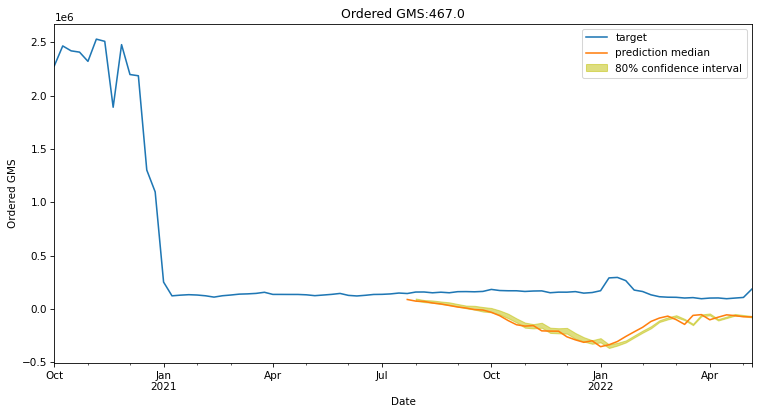

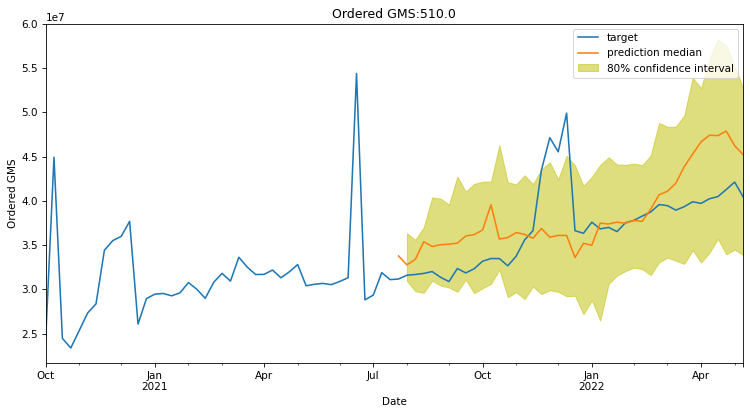

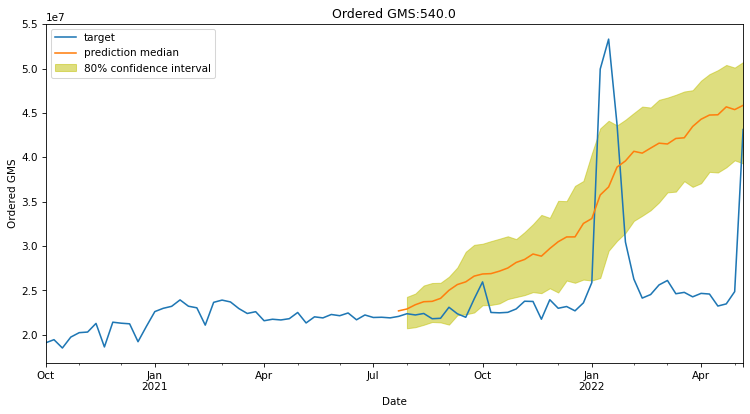

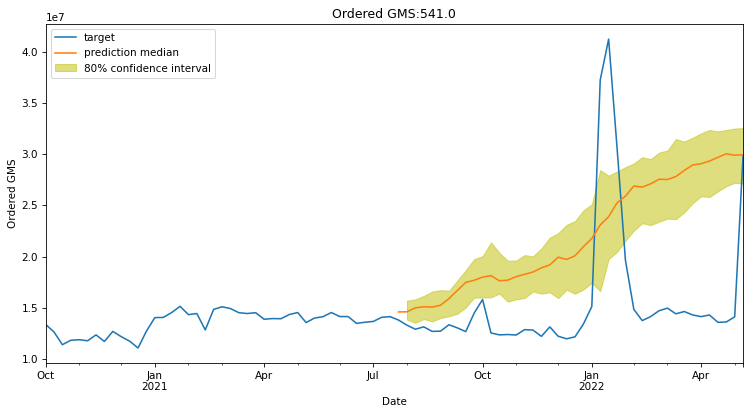

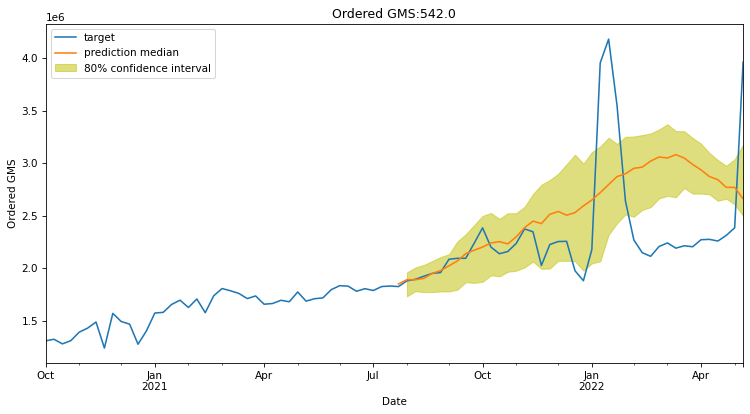

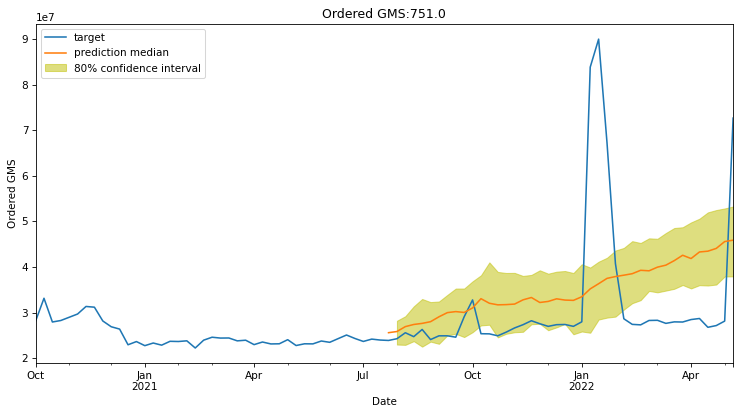

In [32]:
# weekly frequency with context length 42 (same as predict length)
predictor.set_prediction_parameters(freq, prediction_length)
list_of_df = predictor.predict(gms_list_training[:42])
actual_data = gms_list[:42]
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("Ordered GMS")
    plt.xlabel("Date")
    plt.title("Ordered GMS:" + unique_prod[k].astype(str))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [55]:
gms_list_training[:42]

[2018-04-30    8.286176e+06
 2018-05-07    3.235147e+07
 2018-05-14    3.253046e+07
 2018-05-21    3.108685e+07
 2018-05-28    3.214585e+07
                   ...     
 2021-06-21    7.690088e+07
 2021-06-28    4.454108e+07
 2021-07-05    4.681377e+07
 2021-07-12    5.182914e+07
 2021-07-19    4.966750e+07
 Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 169, dtype: float64,
 2018-04-30    2.459194e+07
 2018-05-07    9.845662e+07
 2018-05-14    9.449464e+07
 2018-05-21    8.951149e+07
 2018-05-28    8.960112e+07
                   ...     
 2021-06-21    2.352032e+08
 2021-06-28    1.804363e+08
 2021-07-05    1.809110e+08
 2021-07-12    1.922360e+08
 2021-07-19    1.916613e+08
 Freq: W-MON, Name: DDAA_ORDER_GMS, Length: 169, dtype: float64,
 2018-04-30    9.281194e+06
 2018-05-07    3.821637e+07
 2018-05-14    3.591003e+07
 2018-05-21    3.493541e+07
 2018-05-28    3.637384e+07
                   ...     
 2021-06-21    1.323591e+08
 2021-06-28    7.433253e+07
 2021-07-05    7.331610e+07
 2

In [42]:
unique_prod

array([ 75., 121., 194., 195., 325., 364., 370., 467., 510., 540., 541.,
       542., 751.])

In [40]:
pd.DataFrame(unique_prod, columns = ['GL_PRODUCT_GROUP']).to_csv('DeepAR_GLProductGroup.csv')

In [44]:
list_of_df

[                   0.1         0.5         0.9
 2021-08-01  48284476.0  53609012.0  59531992.0
 2021-08-08  46212272.0  51172448.0  57385344.0
 2021-08-15  42825352.0  51556284.0  58599828.0
 2021-08-22  46880120.0  54804768.0  63517736.0
 2021-08-29  43596200.0  52352628.0  59016064.0
 2021-09-05  43662728.0  52231272.0  62930904.0
 2021-09-12  44460364.0  52003892.0  61094932.0
 2021-09-19  44462684.0  51650828.0  58335172.0
 2021-09-26  44035404.0  51559096.0  60076008.0
 2021-10-03  43505680.0  50940268.0  59414584.0
 2021-10-10  45077680.0  49753356.0  56948680.0
 2021-10-17  43751308.0  51557368.0  57916652.0
 2021-10-24  38418200.0  46943828.0  54241204.0
 2021-10-31  38543104.0  46325368.0  53780896.0
 2021-11-07  38161524.0  46015920.0  52183728.0
 2021-11-14  37602876.0  43353468.0  50220304.0
 2021-11-21  36534880.0  41871492.0  47993032.0
 2021-11-28  36802008.0  39929244.0  45182116.0
 2021-12-05  32855332.0  36950160.0  42109356.0
 2021-12-12  31012432.0  36461636.0  416

In [46]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / abs(actual))) * 100

def asmape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / np.maximum(abs(actual),abs(pred)))) * 100


for p in range(len(list_of_df)):
    list_of_df[p]['0.5'] 
    
    
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(forecast, test_week)
mae = mean_absolute_error(forecast ,test_week)
mape = mape(test_week, forecast)      
asmape = asmape(test_week, forecast)
            
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The MAE is {}'.format(round(mae), 2))
print('The MAPE is {}'.format(round(mape), 2))
print('The ASMAPE is {}'.format(round(asmape), 2))

2021-08-01    53609012.0
2021-08-08    51172448.0
2021-08-15    51556284.0
2021-08-22    54804768.0
2021-08-29    52352628.0
2021-09-05    52231272.0
2021-09-12    52003892.0
2021-09-19    51650828.0
2021-09-26    51559096.0
2021-10-03    50940268.0
2021-10-10    49753356.0
2021-10-17    51557368.0
2021-10-24    46943828.0
2021-10-31    46325368.0
2021-11-07    46015920.0
2021-11-14    43353468.0
2021-11-21    41871492.0
2021-11-28    39929244.0
2021-12-05    36950160.0
2021-12-12    36461636.0
2021-12-19    35282572.0
2021-12-26    33557964.0
2022-01-02    34370792.0
2022-01-09    33127638.0
2022-01-16    36063652.0
2022-01-23    35083988.0
2022-01-30    34998924.0
2022-02-06    34746048.0
2022-02-13    35124004.0
2022-02-20    35570016.0
2022-02-27    35995856.0
2022-03-06    35790048.0
2022-03-13    36443660.0
2022-03-20    36904900.0
2022-03-27    37362168.0
2022-04-03    36471420.0
2022-04-10    37258520.0
2022-04-17    36404192.0
2022-04-24    34998460.0
2022-05-01    35095188.0
